This notebook performs the synthesis using our proposed synthesization approach applied to the South Korean COVID-19 data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools

from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/SK/cleaned_sk_data.csv")

In [3]:
train_data

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,1,5,0
1,0.889746,-0.694899,1,5,0
2,0.917482,-0.682299,1,3,0
3,0.916660,-0.682551,1,3,0
4,0.886074,-0.668883,1,3,0
...,...,...,...,...,...
6707,0.881500,-0.925307,1,4,0
6708,-1.728784,1.470871,1,4,0
6709,-1.548071,1.557316,1,4,0
6710,-1.549392,1.555785,1,4,0


***

# Full Sequential Synthesis Driven by Bayesian Optimization

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [15]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_sex_,
                 mb_age_,
                 mb_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=train_data.loc[:,["latitude", "longitude"]], y=train_data.loc[:,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,["latitude", "longitude"]]).toarray()
    
    node_outcomes = [train_data.sex[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,["latitude", "longitude"]])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ####################################################################################################
        
    ########### Code for age CART ##########
    cart_age = DecisionTreeClassifier(min_samples_leaf=mb_age_, random_state=rng)
    
    cart_age.fit(X=train_data.loc[:,["latitude", "longitude", "sex"]], y=train_data.loc[:,"age"])
    
    node_indicators = cart_age.decision_path(train_data.loc[:,["latitude", "longitude", "sex"]]).toarray()
    
    node_outcomes = [train_data.age[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_age.apply(sXs[i].loc[:,["latitude", "longitude", "sex"]])
        
        new_age = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_age[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_age = pd.Series(new_age)
        
        new_age.name = "age"
        
        sXs[i] = pd.concat([sXs[i], new_age], axis=1)
        
    ####################################################################################################
    
    ########### Code for state CART ##########
    
    cart_state = DecisionTreeClassifier(min_samples_leaf=mb_state_, random_state=rng)
    
    cart_state.fit(X=train_data.loc[:,["latitude", "longitude", "sex", "age"]], y=train_data.loc[:,"state"])
    
    node_indicators = cart_state.decision_path(train_data.loc[:,["latitude", "longitude", "sex", "age"]]).toarray()
    
    node_outcomes = [train_data.state[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_state.apply(sXs[i].loc[:,["latitude", "longitude", "sex", "age"]])
        
        new_state = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_state[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_state = pd.Series(new_state)
        
        new_state.name = "state"
        
        sXs[i] = pd.concat([sXs[i], new_state], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [16]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_sex_, mb_age_, mb_state_):

        pmse_ratios, current_sXs, current_GMM = train_models(train_data=train_data,
                                                             number_synthetic_datasets=number_synthetic_datasets,
                                                             number_gmm_initializations=number_gmm_initializations,
                                                             num_components_=int(num_components_),
                                                             mb_sex_=int(mb_sex_),
                                                             mb_age_=int(mb_age_),
                                                             mb_state_=int(mb_state_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "mb_sex_": (10, 300.99),
            "mb_age_": (10, 300.99),
            "mb_state_": (10, 300.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [6]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [7]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  mb_age_  |  mb_sex_  | mb_state_ | num_co... |
-------------------------------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 1         | -0.7189   | 226.2     | 75.89     | 197.0     | 178.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 2         | -0.637    | 225.5     | 219.9     | 95.94     | 110.4     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 3         | -0.2081   | 60.56     | 246.3     | 257.2     | 58.99     |
| 4         | -0.08185  | 79.03     | 143.4     | 76.61     | 48.58     |
| 5         | -1.152    | 296.0     | 295.4     | 223.8     | 88.17     |
| 6         | -0.05377  | 77.81     | 140.8     | 74.75     | 58.18     |
| 7         | -0.009824 | 10.0      | 147.6     | 75.08     | 122.1     |
| 8         | -0.009202 | 45.48     | 61.81     | 10.0      | 108.0     |
| 9         | -0.003293 | 63.11     | 151.4     | 10.0      | 123.1     |
| 10        | -0.3437   | 67.48     | 244.5     | 263.9     | 53.99     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 11        | -0.296    | 12.19     | 252.7     | 212.2     | 88.91     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 12        | -0.2752   | 84.56     | 147.9     | 83.65     | 47.33     |
| 13        | -0.01551  | 61.87     | 133.2     | 55.8      | 48.97     |
| 14        | -0.08254  | 40.95     | 135.6     | 41.05     | 113.2     |
| 15        | -0.003159 | 62.35     | 102.6     | 10.0      | 113.6     |
| 16        | -0.00784  | 46.43     | 138.9     | 43.01     | 118.0     |
| 17        | -0.06645  | 69.23     | 140.1     | 41.94     | 138.8     |
| 18        | -0.01301  | 43.65     | 167.5     | 56.63     | 125.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

| 19        | -0.002919 | 74.62     | 151.1     | 36.21     | 100.9     |
| 20        | -0.04367  | 80.1      | 143.4     | 76.96     | 49.41     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 21        | -0.08671  | 88.56     | 138.7     | 71.45     | 52.74     |
| 22        | -5.952e-0 | 61.77     | 147.8     | 32.56     | 117.2     |
| 23        | -0.03254  | 53.77     | 153.9     | 48.24     | 121.0     |
| 24        | -0.002196 | 64.29     | 133.5     | 19.8      | 118.1     |
| 25        | -0.02002  | 30.65     | 151.9     | 62.0      | 124.3     |
| 26        | -0.002246 | 73.2      | 148.0     | 19.19     | 109.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 27        | -0.003003 | 68.66     | 133.8     | 39.34     | 110.8     |
| 28        | -0.001061 | 63.03     | 112.8     | 27.84     | 119.0     |
| 29        | -0.05381  | 52.91     | 82.99     | 16.14     | 112.2     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 30        | -0.008099 | 69.41     | 118.5     | 20.06     | 102.7     |
Final Result:  {'target': -5.951928826699583e-06, 'params': {'mb_age_': 61.770216440792865, 'mb_sex_': 147.83291807891626, 'mb_state_': 32.55645208348893, 'num_components_': 117.18473158818902}}
|   iter    |  target   |  mb_age_  |  mb_sex_  | mb_state_ | num_co... |
-------------------------------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

| 1         | -0.6772   | 248.2     | 264.4     | 131.8     | 95.03     |
| 2         | -0.1551   | 47.41     | 40.54     | 198.0     | 193.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

| 3         | -0.3008   | 94.61     | 29.42     | 153.3     | 86.85     |
| 4         | -0.0507   | 73.42     | 252.8     | 63.0      | 89.95     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 5         | -0.01742  | 100.0     | 297.2     | 21.89     | 66.4      |
| 6         | -0.01106  | 38.21     | 287.5     | 10.0      | 70.07     |
| 7         | -0.007493 | 69.71     | 244.7     | 61.9      | 96.69     |
| 8         | -0.01769  | 49.85     | 220.1     | 27.1      | 126.4     |
| 9         | -0.000998 | 38.03     | 287.4     | 10.1      | 69.07     |
| 10        | -0.008951 | 36.83     | 283.3     | 13.22     | 42.55     |
| 11        | -0.01938  | 55.41     | 214.3     | 54.32     | 100.7     |
| 12        | -0.06402  | 73.62     | 232.2     | 59.31     | 130.7     |
| 13        | -0.000245 | 20.89     | 287.5     | 10.69     | 57.68     |
| 14        | -0.000235 | 42.14     | 271.8     | 10.58     | 58.58     |
| 15        | -0.02658  | 32.22     | 241.8     | 71.28     | 106.2     |
| 16        | -0.000838 | 41.82     | 294.2     | 11.5      | 55.7      |
| 17        | -0.002701 | 33.72     | 282.6     | 23.18     | 60.06     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 18        | -0.08964  | 138.5     | 298.4     | 10.62     | 51.32     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 19        | -0.1623   | 63.3      | 223.1     | 95.63     | 93.49     |
| 20        | -0.02609  | 72.63     | 231.6     | 31.97     | 98.04     |
| 21        | -0.002613 | 13.85     | 216.6     | 36.07     | 106.2     |
| 22        | -1.802e-0 | 10.0      | 225.3     | 46.35     | 141.7     |
| 23        | -0.008862 | 13.96     | 188.7     | 34.39     | 136.3     |
| 24        | -0.008061 | 10.0      | 217.5     | 10.0      | 139.7     |
| 25        | -0.002721 | 17.65     | 207.6     | 29.01     | 179.1     |
| 26        | -0.000463 | 10.0      | 193.9     | 67.51     | 173.1     |
| 27        | -0.01297  | 25.26     | 166.0     | 41.81     | 183.0     |
| 28        | -0.000175 | 10.0      | 233.8     | 63.51     | 189.3     |
| 29        | -0.03687  | 37.63     | 204.5     | 61.53     | 201.0     |
| 30        | -0.00284  | 10.0      | 252.1     | 27.14     | 178.3     |
Final Result:  {'target': -1.8021203876846898e-06, 'params': {'mb_age_': 10.0, 'mb_sex_': 225.25275473224514, 'm

***

In [8]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

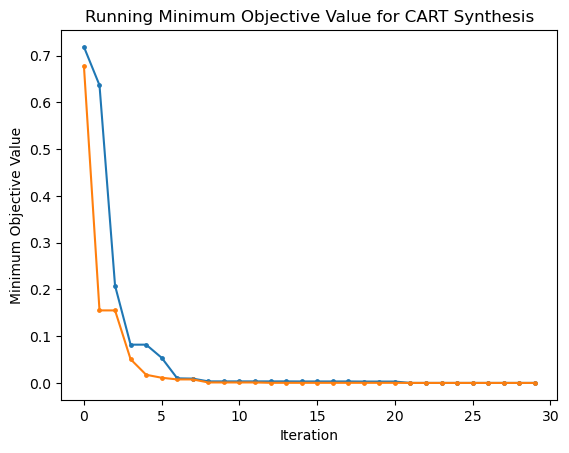

In [9]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [10]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [11]:
best_params

{'target': -1.8021203876846898e-06,
 'params': {'mb_age_': 10.0,
  'mb_sex_': 225.25275473224514,
  'mb_state_': 46.346511624680986,
  'num_components_': 141.74997353448947}}

***

In [17]:
pmse_ratios, full_sXs, GMM = train_models(train_data=train_data,
                                          number_synthetic_datasets=20,
                                          # hyperparameters for GMM
                                          number_gmm_initializations=ngi,
                                          num_components_=int(best_params['params']['num_components_']),
                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                          mb_sex_=int(best_params['params']['mb_sex_']),
                                          mb_age_=int(best_params['params']['mb_age_']),
                                          mb_state_=int(best_params['params']['mb_state_']))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
np.mean(pmse_ratios)

1.012088300125321

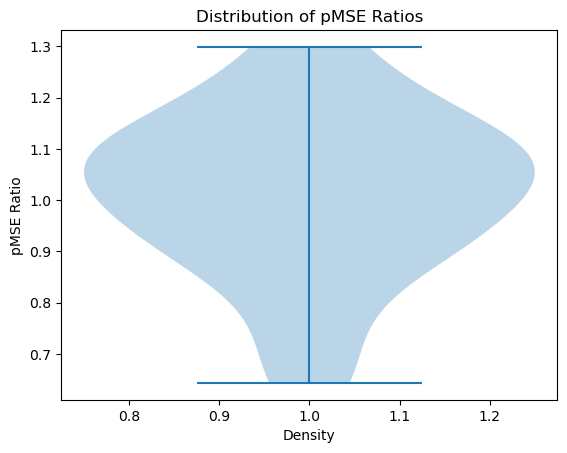

In [19]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

In [20]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/SK/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv", index=False)

***

Now apply the attribute disclosure prevention algorithm.

Based on publicly available data from the World Health Organization, we use the total number of confirmed COVID-19 cases (9,583) and total number of deaths (152) in South Korea as of March 23, 2020 to calculate the prior probability $p(S_j = 1 | x_j^q, b) = 152/9583 \approx 0.016$ and $p(S_j = 0 | x_j^q, b) = 1 - 0.016 = 0.984$..984.

In [21]:
prior = 152/9583

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the correct disease status based on the synthetic data. This is a relatively large increase. For example, this means going from 0.016 under the prior to no more than 0.16 under the updated probability.

In [22]:
c = 10

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [23]:
deltas = np.linspace(0.001, 1, 5)

In [24]:
ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
                                         synthetic_data=X,
                                         continuous_vars=['latitude', 'longitude'],
                                         categorical_vars=['sex', 'age'],
                                         sensitive_var='state',
                                         mixture_model=GMM,
                                         deltas=deltas, 
                                         c=c, 
                                         prior_prob=prior) for X in full_sXs]

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.001


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.25075


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.5005


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 0.75025


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


In [25]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv", index=False)